In [1]:
import librosa
import numpy as np
from scipy.signal import convolve, deconvolve
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt
import pyloudnorm
import soundfile

In [2]:
# Function to plot an audio signal
def plot_signal(signal, title, sr=22050, label=None, start=0, length=None):
    length = len(signal) if length is None else length
    sig = signal[start:start+length]
    plt.figure(figsize=(20, 4))
    plt.plot(np.linspace(0, len(sig) / sr, num=len(sig)), sig, label=label)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid()

In [3]:
# Load the audio files
dry_signal, sr = librosa.load('samples/Eastman piezo 0009 [2023-12-30 162118].aif', sr=None)
target_signal, _ = librosa.load('samples/Eastman mic 0009 [2023-12-30 162118].aif', sr=None)

In [4]:
sr

48000

In [5]:
def rms(signal):
    return np.sqrt(np.mean(signal **2))
def peak(signal):
    return np.max(np.abs(signal))
def loudness(signal, sr):
    meter = pyloudnorm.Meter(sr)
    return meter.integrated_loudness(signal)

In [6]:
def normalised(signal, mode, based_on_signal, sr=None):
    if mode == 'rms':
        scaling_factor = rms(based_on_signal)/rms(signal)
        return signal * scaling_factor
    elif mode == 'peak':
        scaling_factor = peak(based_on_signal)/peak(signal)
        return signal * scaling_factor
    elif mode == 'loudness':
        meter = pyloudnorm.Meter(sr)
        target_loudness = meter.integrated_loudness(based_on_signal)
        raw_loudness = meter.integrated_loudness(signal)
        return pyloudnorm.normalize.loudness(signal, raw_loudness, target_loudness)
    elif mode == 'none':
        return signal
    else:
        raise ValueError('invalid mode')
    
    

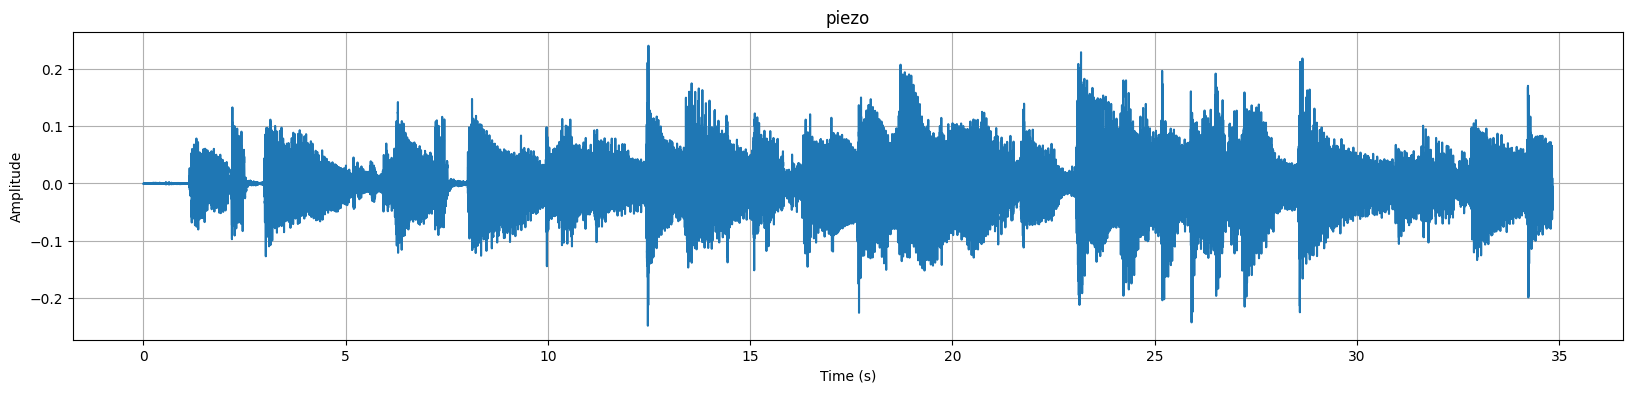

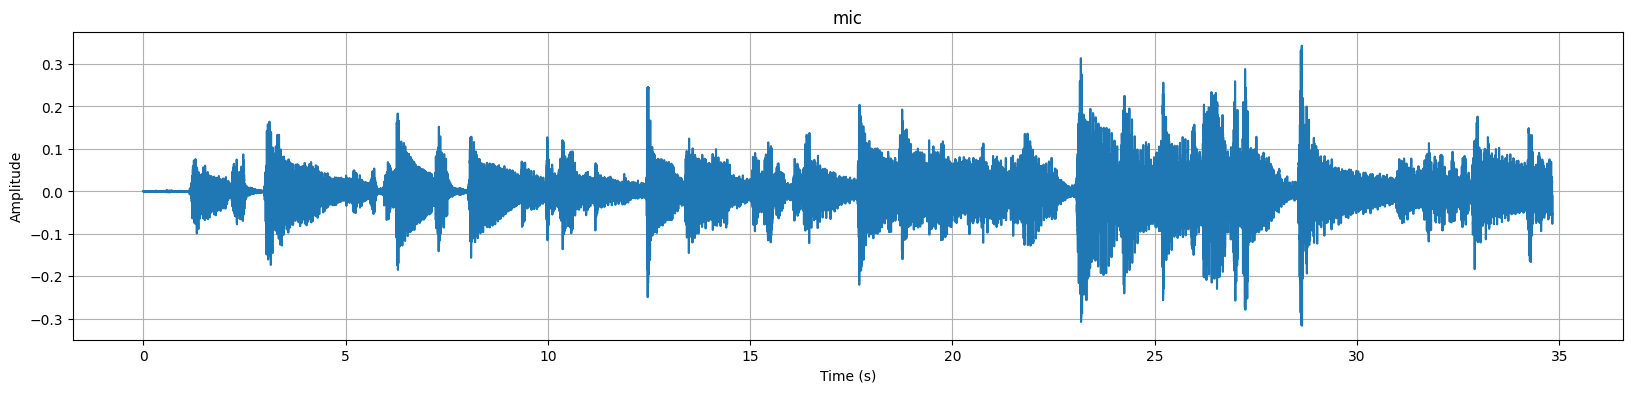

In [7]:
plot_signal(dry_signal,'piezo')
plot_signal(target_signal,'mic')

In [8]:
[ loudness(s, sr) for s in [dry_signal, target_signal]]

[-29.619186714467855, -28.412892578585605]

In [9]:
[ peak(s) for s in [dry_signal, target_signal]]

[0.24911797, 0.34306479]

In [10]:
[ rms(s) for s in [dry_signal, target_signal]]

[0.036514558, 0.042429946]

In [11]:
[len(s) for s in [dry_signal, target_signal]]

[768000, 768000]

In [12]:
def compare_signals(sig1, sig2, title1, title2, sr):
    # Adjust the length of the dry-transformed signal to match the target signal
    if len(sig1) > len(sig2):
        sig1 = sig1[:len(sig2)]
    else:
        sig2 = sig2[:len(sig1)]

    difference = sig1-sig2

    # Plot the 2 signals
    #plt.subplot(2, 1, 1)
    plot_signal(sig1, title1, sr, label=title1)
    plt.legend()
    plot_signal(sig2, title2, sr, label=title2)
    plt.legend()
    
    # Plot the difference signal
    #plt.subplot(2, 1, 2)
    plot_signal(difference, 'Difference Signal', sr)



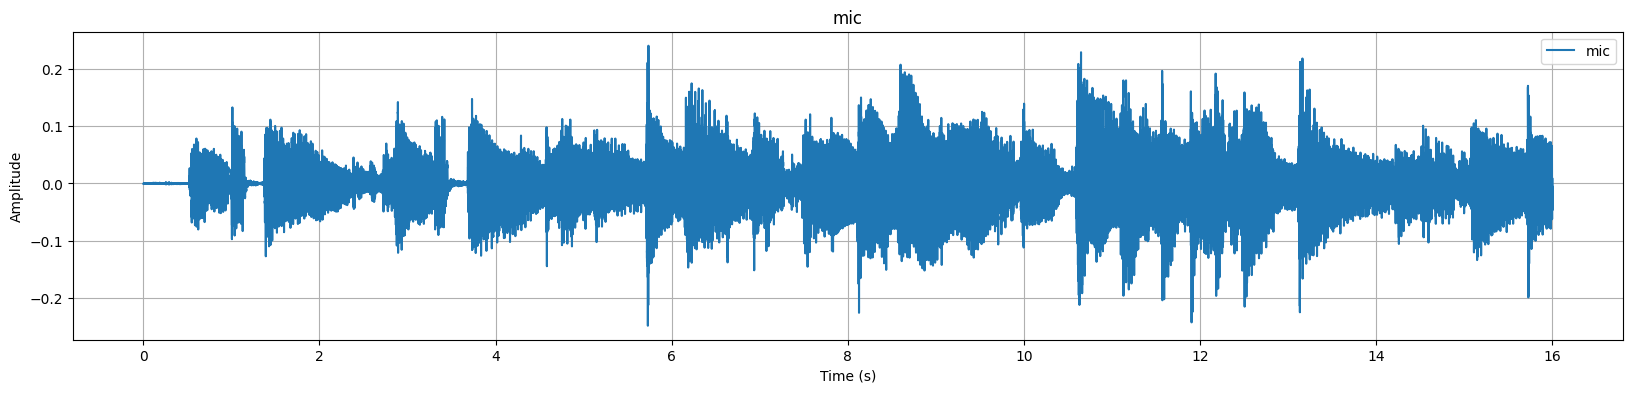

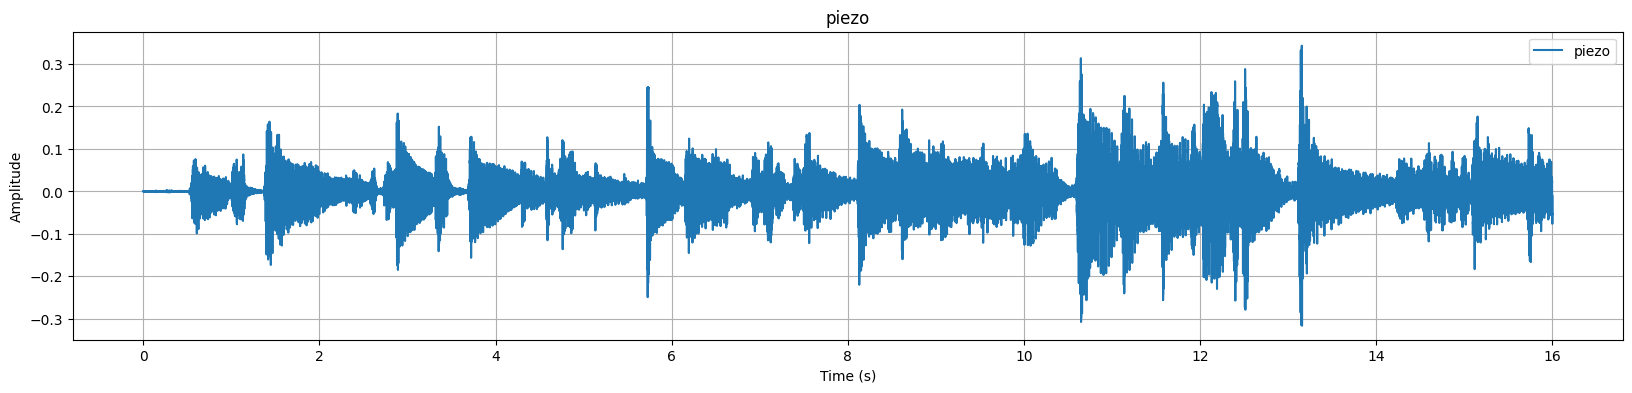

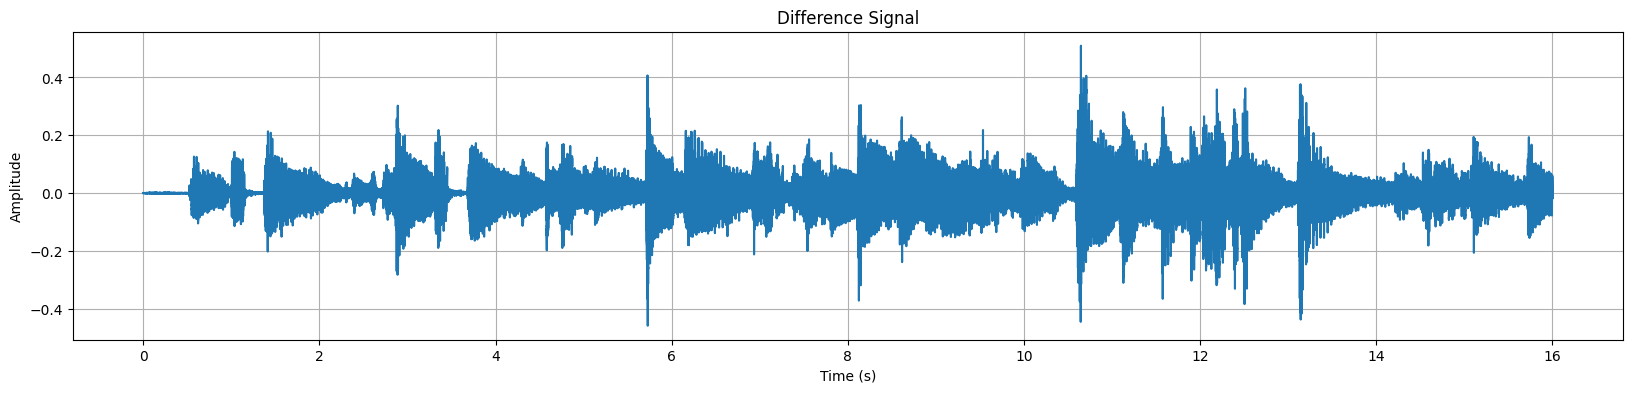

In [13]:
compare_signals(dry_signal, target_signal, 'mic', 'piezo', sr)

In [14]:
loudness(target_signal, sr)

-28.412892578585605

In [15]:
rms(dry_signal)

0.036514558

In [16]:
rms(normalised(dry_signal, 'loudness', target_signal,sr))

0.041954707

In [17]:
START=25000
SAMPLES=5000
x = dry_signal[START:START+SAMPLES]
y = target_signal[START:START+SAMPLES]


In [18]:
rms_diff = normalised(y, 'rms', x)-x
peak_diff = normalised(y, 'peak',x)-x
loudness_diff = normalised(y, 'peak', x, sr)-x

print(rms(rms_diff), rms(peak_diff), rms(loudness_diff))

0.031920064 0.030235734 0.030235734


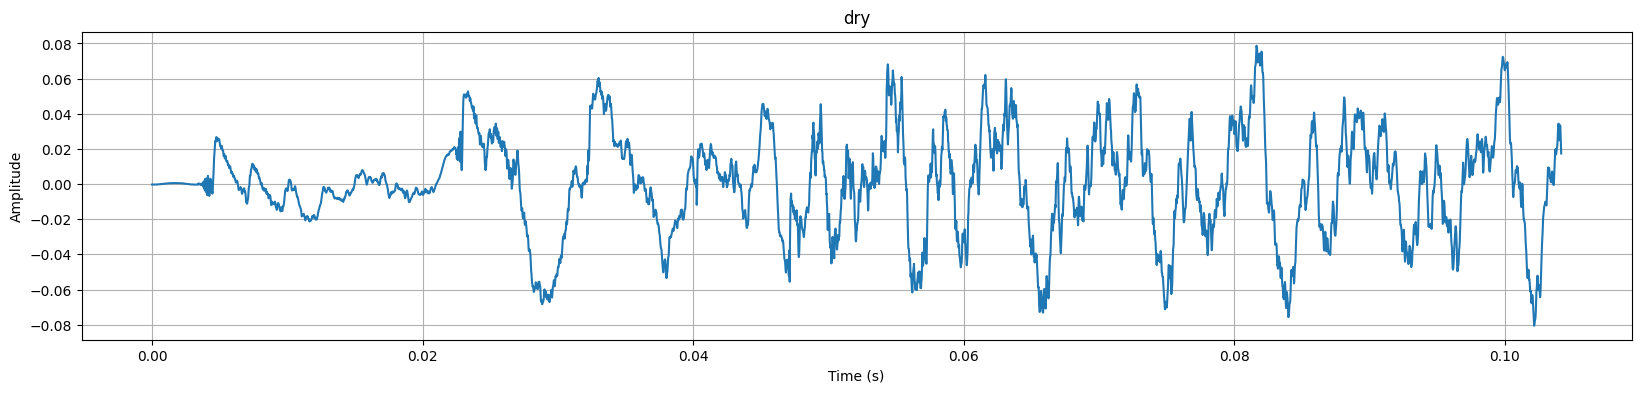

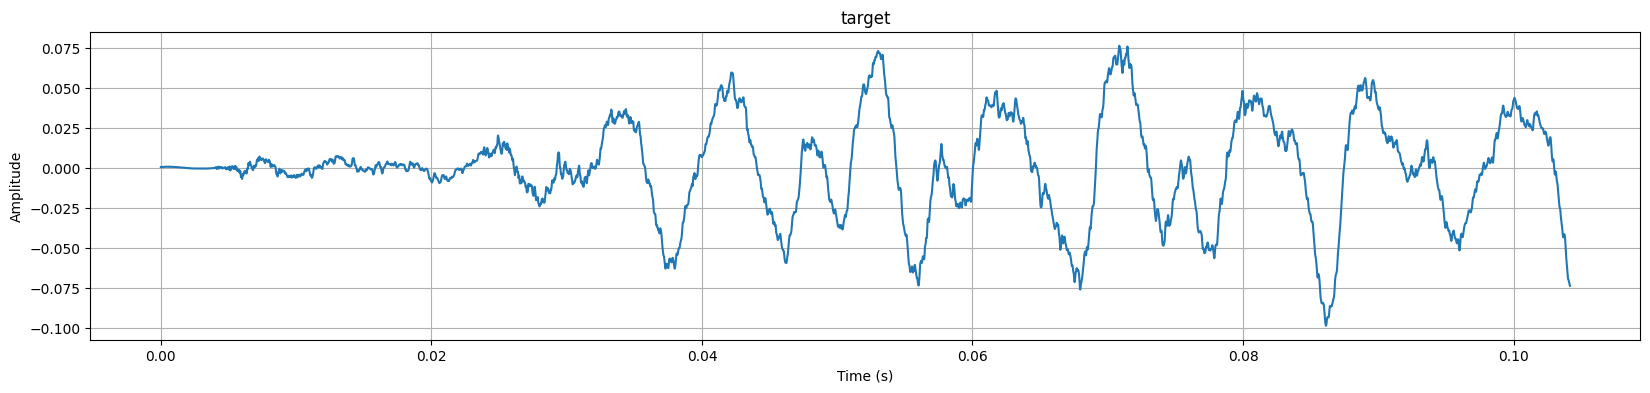

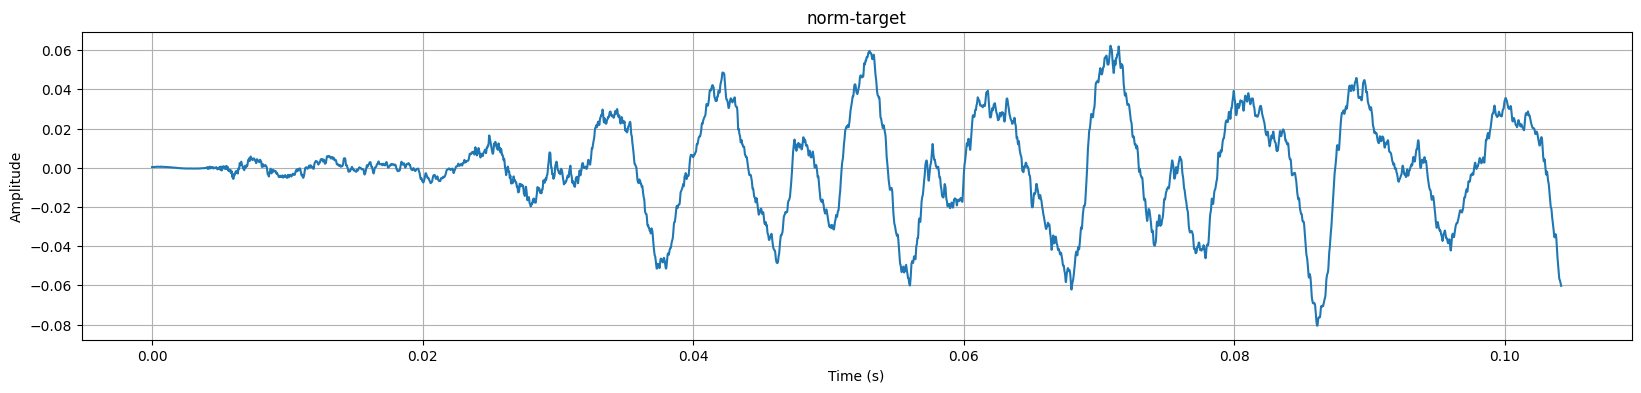

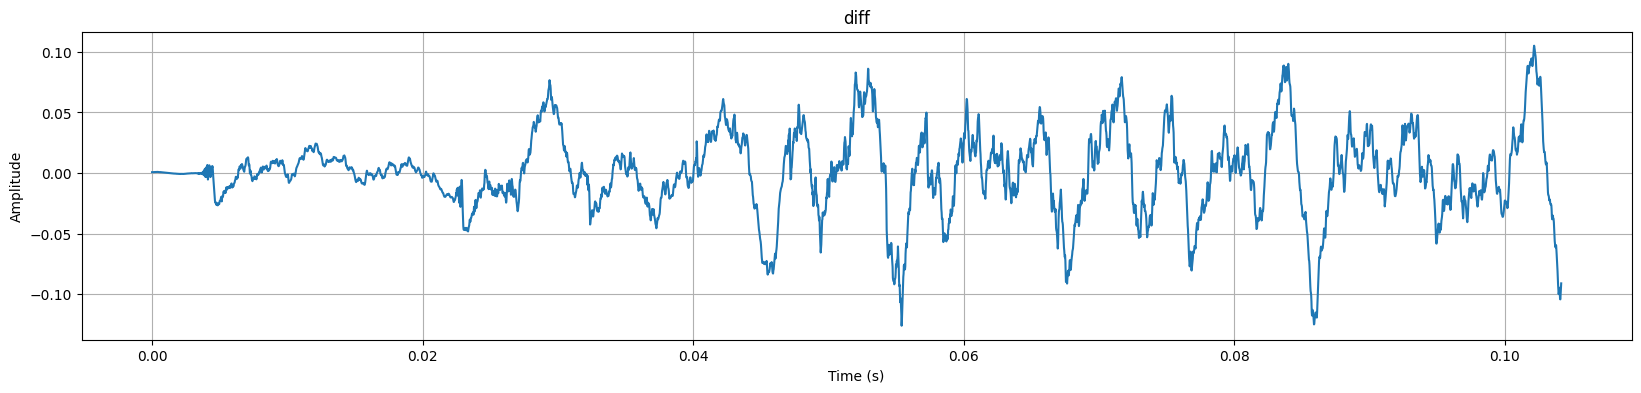

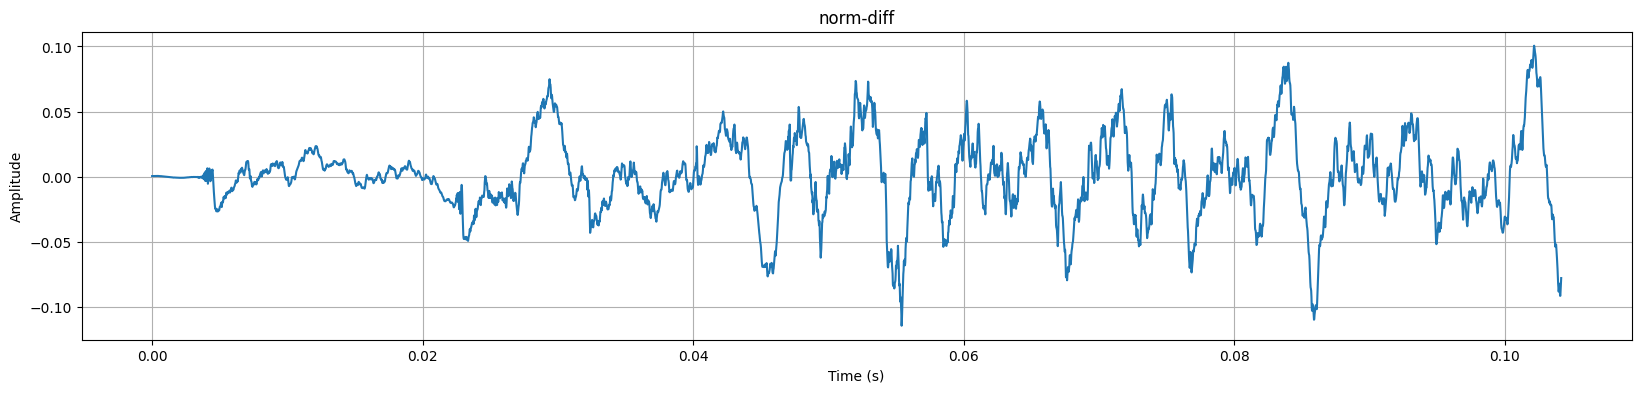

In [19]:
plot_signal(x, 'dry', sr)
plot_signal(y, 'target', sr)
plot_signal(normalised(y, 'peak', x, sr), 'norm-target', sr)
plot_signal(y-x, 'diff', sr)
plot_signal(normalised(y, 'peak', x, sr)-x, 'norm-diff', sr)

In [20]:
len(target_signal)

768000

In [21]:
len(dry_signal)

768000

In [22]:
def create_impulse_response(dry_signal, target_signal, length=2048):
    fft_dry = fft(dry_signal)
    fft_target = fft(target_signal)
    epsilon = 1e-10
    impulse_response_fft = fft_target / (fft_dry+epsilon)
    impulse_response = np.real(ifft(impulse_response_fft))
    return impulse_response[:length]

In [23]:
impulse_response = create_impulse_response(dry_signal, target_signal, 2048)

In [24]:
impulse_response

array([ 0.00157407, -0.00247113, -0.00991014, ..., -0.00015067,
        0.00037233, -0.00116911], dtype=float32)

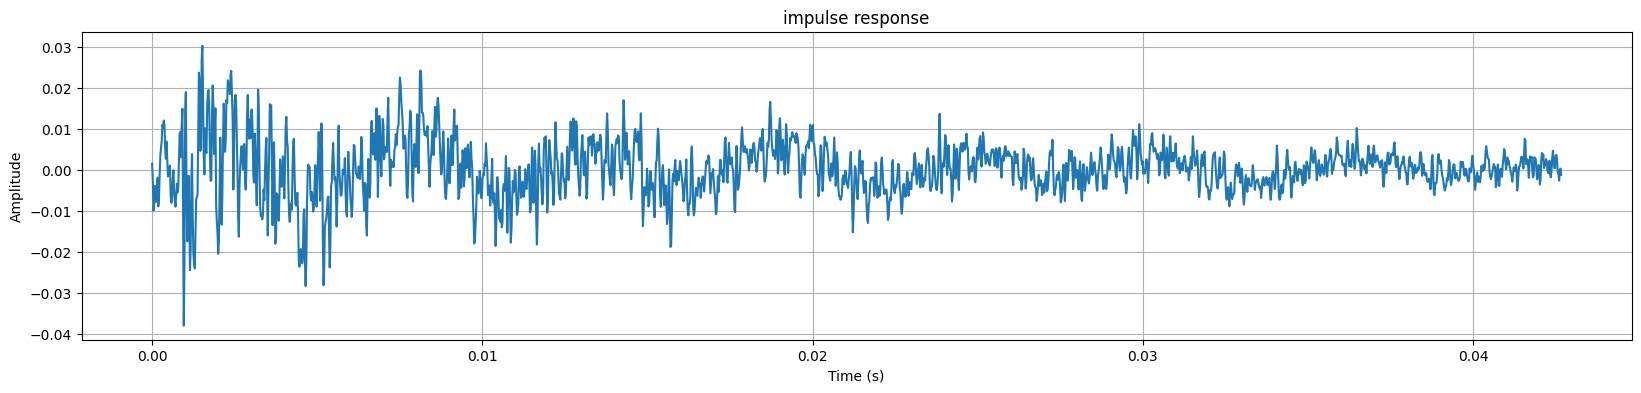

In [25]:
plot_signal(impulse_response, 'impulse response',sr)

In [26]:
processed_dry = convolve(dry_signal, impulse_response)
signal_diff = processed_dry[:len(target_signal)]-target_signal
[rms(s) for s in [dry_signal, target_signal, processed_dry, signal_diff]]

[0.036514558, 0.042429946, 0.037363376, 0.019074185]

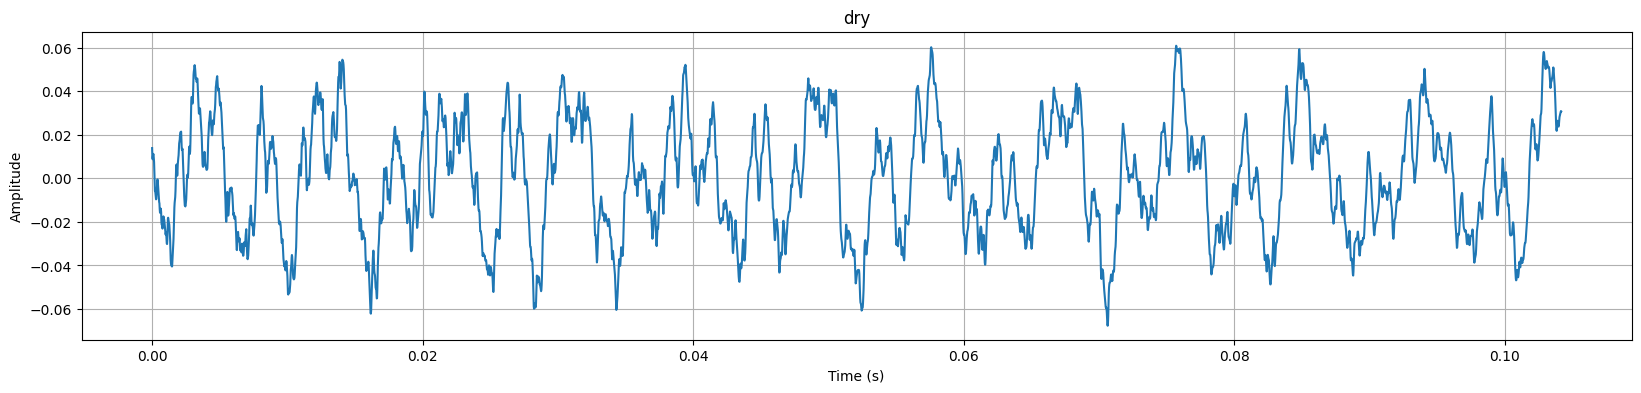

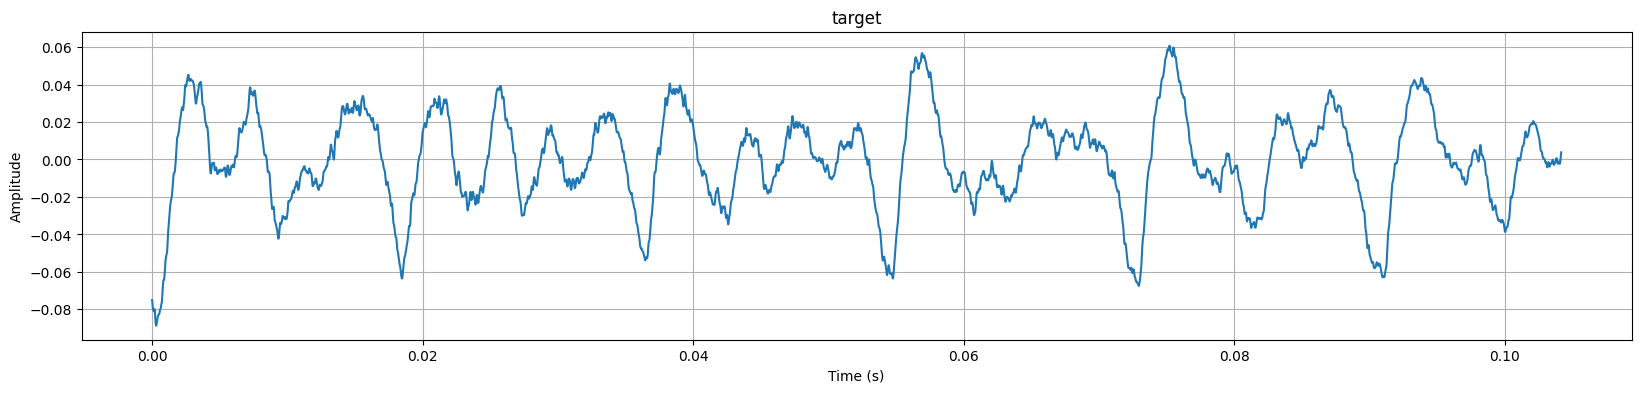

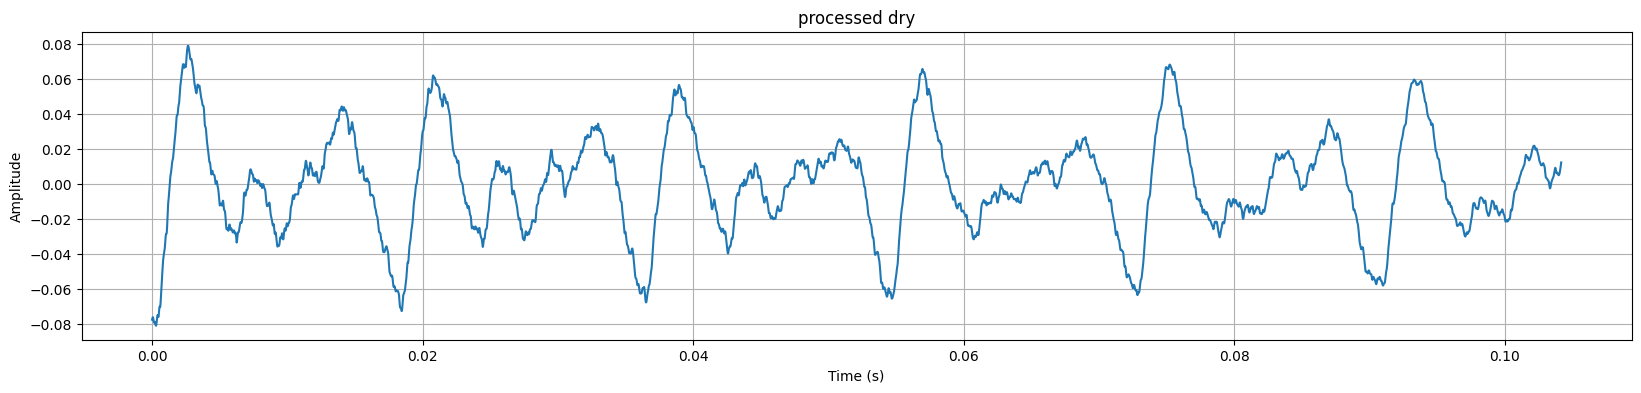

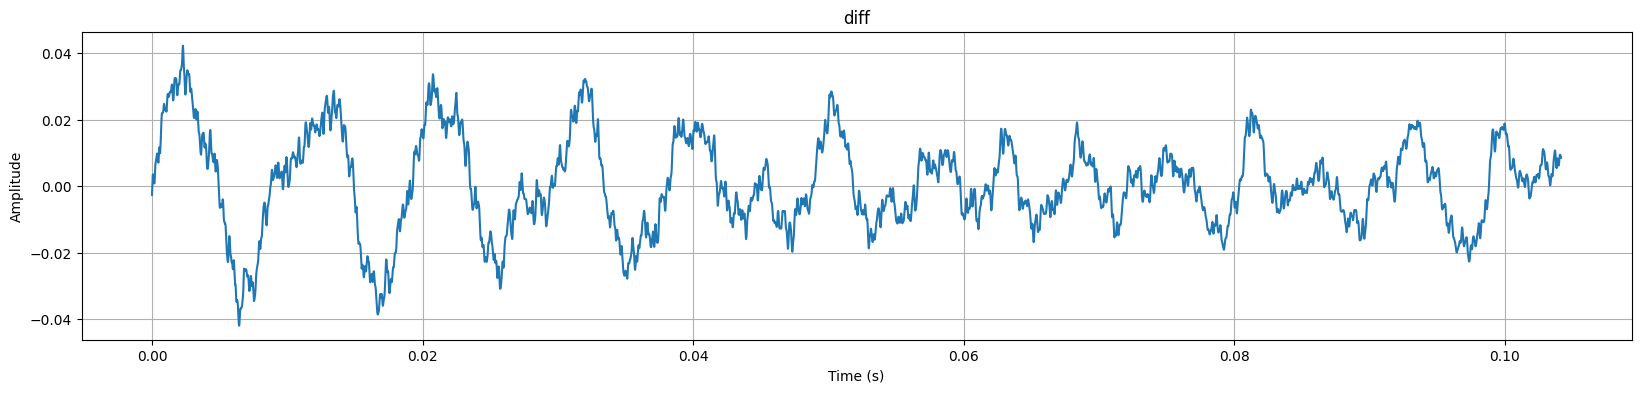

In [27]:
START=30000
LENGTH=5000
plot_signal(dry_signal, 'dry',sr, start=START, length=LENGTH)
plot_signal(target_signal, 'target',sr,start=START, length=LENGTH)
plot_signal(processed_dry, 'processed dry',sr,start=START, length=LENGTH)
plot_signal(signal_diff, 'diff',sr,start=START, length=LENGTH)

In [28]:
#soundfile.write('IR-name.wav', impulse_response, sr)